# MCMC in Mixture Models

# Data generations:

### Finite Mixture of Gaussians

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def is_prob(p):
    p = np.array(p)
    if np.any(p<0):
        return False
    elif np.sum(p)!=1:
        return False
    else:
        return True

def generate_mixture(mu, pi, sample_size, sigma2=1):
    K, d = np.shape(mu)
    if (len(pi)!=K) or (is_prob(pi)==False):
        raise ValueError('Incorrect dimensions or mixing prob')
    z = np.random.choice(K, p=pi, size=sample_size)
    data = np.zeros((sample_size, d))
    for i in range(sample_size):
        theta = mu[z[i],:]
        data[i,:] = np.random.multivariate_normal(theta, sigma2*np.eye(d), size=1)
    return data, z

### HMM with Gaussian emission

In [3]:
def generate_HMM(mu, Pi, sample_size, sigma2=1):
    K, d = np.shape(mu)
    if (np.shape(Pi)[0]!=K) or (np.shape(Pi)[1]!=K) or (np.any([is_prob(Pi[i,:]) for i in range(np.shape(Pi)[0])]) == False):
        raise ValueError('Incorrect dimensions or transition prob')
    z = np.zeros(sample_size, dtype=int)
    data = np.zeros((sample_size, d))
    for i in range(sample_size):
        if i>0:
            z[i] = np.random.choice(K, p=Pi[z[i-1],:], size=1)[0]
        theta = mu[z[i],:]
        data[i,:] = np.random.multivariate_normal(theta, sigma2*np.eye(d), size=1)
    return data, z

### DP Mixture

In [4]:
def generate_DPmixture(alpha, P0, sample_size, sigma2=1):
    # use the Polya urn characterization
    # P0 is (mu0, sigma02) <- parameters of base measure (normal)
    #    Model: P ~ DP(alpha P0), phi1,...phin|P ~ P, X_i|phi_i ~ N(phi_i, sigma2)

    mu0, sigma02 = P0
    d = len(mu0)
    theta = np.zeros((sample_size, d))
    
    mu = []
    labels = []
    K = 0
    
    for i in range(sample_size):
        if i==0:
            theta[i,:] = np.random.multivariate_normal(mu0, sigma02*np.eye(d), size=1)
            mu.append(theta[i,:])
            labels.append(0)
            K = 1
        else:
            pi = np.ones(K+1)
            pi[-1] = alpha
            pi = pi/np.sum(pi)
            z = np.random.choice(K+1, p=pi, size=1)[0]
            if z<K:
                theta[i,:] = mu[z]
                labels.append(z)
            else:
                theta[i,:] = np.random.multivariate_normal(mu0, sigma02*np.eye(d), size=1)
                labels.append(K)
                mu.append(theta[i,:])
                K = K + 1
    data = theta + np.random.multivariate_normal(np.zeros(d), sigma2*np.eye(d), size=sample_size)
    return data, np.array(mu).reshape(K,d), labels, K

Text(0.5, 1.0, 'True data DP mixture, alpha=0.1')

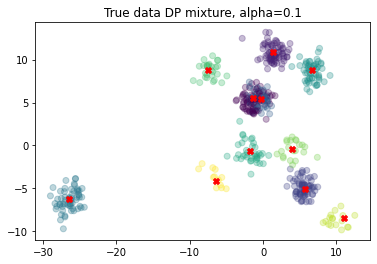

In [5]:
data_DP, mu_DP, labels_DP, K_DP = generate_DPmixture(0.1, ([0,0], 50), 500)
plt.scatter(data_DP[:,0], data_DP[:,1], c=labels_DP, alpha=0.3)
plt.scatter(mu_DP[:,0], mu_DP[:,1], marker='X', color='red')
plt.title('True data DP mixture, alpha=0.1')

Text(0.5, 1.0, 'True data finite mixture')

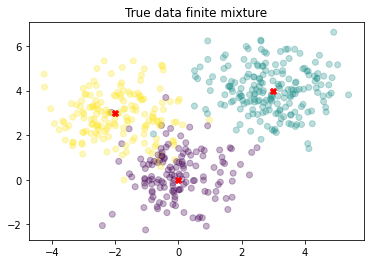

In [6]:
mu_mixture = np.array([[0,0], [3,4], [-2, 3]])
data_mixture, labels_mixture = generate_mixture(mu_mixture, [0.3, 0.4, 0.3], 500)
plt.scatter(data_mixture[:,0], data_mixture[:,1], c=labels_mixture, alpha=0.3)
plt.scatter(mu_mixture[:,0], mu_mixture[:,1], marker='X', color='red')
plt.title('True data finite mixture')

### Normal Likelihood and Posterior helper functions
Let $X^{(n)} = (X_1,\dots,X_n)\overset{iid}{\sim}N(\mu, \sigma^2 I)$ where $\mu\in\mathbb{R}^d$ is given the prior $\mu \sim N(\mu_0, \tau_0^2 I)$. Then by conjugacy we have the posterior as $\mu|X^{(n)} \sim N\left(\mu_n, \sigma_n^2 I\right)$ where

$$\begin{align}
\mu_n &= \sigma_n^2 \left(\frac{\bar{X}}{\sigma^2/n} + \frac{\mu_0}{\tau^2}\right)\\
\sigma_n^2 &= \frac{1}{1/\tau_0^2 + n/\sigma^2}\\
\end{align}$$

The posterior predictive distribution is then $x^*|X^{(n)} \sim N(\mu_n, (\sigma_n^2+\sigma^2)I)$.

In [7]:
def phi(x, mu, sigma2):
    d = len(x)
    if (len(mu)!=d) or (sigma2<0):
        raise ValueError('Incorrect dimension or sigma2 negative')
    return stats.multivariate_normal.pdf(x, mean=mu, cov=sigma2*np.eye(d))

def posterior(X, mu0, tau02, sigma2):
    # posterior of mu given data, prior is N(mu0, tau0^2)
    n,d = np.shape(X)
    if (len(mu0)!=d) or (tau02<0) or (sigma2<0):
        raise ValueError('Incorrect dimension or var negative')
    sigma2_n = 1/(1/tau02 + n/sigma2)
    Xbar = np.mean(X, axis=0)
    mu_n = sigma2_n * (Xbar/(sigma2/n) + mu0/tau02)
    return mu_n, sigma2_n
    
def conditional_likelihood(x_new, posterior_mu, sigma2):
    mu_n, sigma2_n = posterior_mu
    if (len(x_new)!=len(mu_n)) or (sigma2<0):
        raise ValueError('Incorrect dimension or var negative')
    return phi(x_new, mu_n, (sigma2_n+sigma2))

## 1. Finite Mixture of Gaussians with known covariance

Consider a finite mixture of multivariate normals with known variance $\sigma^2 I$:
$$y_i|z_i \sim N(\mu_{z_i}, \sigma^2 I), \quad z_i \overset{iid}{\sim} \text{Cat}(\pi), \quad i=1,\dots, n$$
where $\pi\in\Delta^{K-1}$ and $\mu_1,\dots,\mu_K\in \mathbb{R}^d$ are the model parameters.

We give priors $\mu_j \sim N(\mu_{j0}, \tau_{j0}^2 I)$ independently for $i=1,\dots,K$ and $\pi\sim\text{Dir}_K(\alpha_0)$ for hyperparameters $\{\{\mu_{j0},\tau_{j0}^2\}_{j\in[K]}, \alpha_0\}$.

The joint distribution is $P(Z,X|\pi,\mu) = \prod_{i=1}^n \pi_{z_i} \phi(x_i|\mu_{z_i},\sigma^2 I)$ based on $X=(X_1,\dots,X_n)$ (observations) and $Z=(Z_1,\dots,Z_n)$ (latent auxilliary variables). The goal is to draw from $P(Z,\pi,\mu|X)$ and we use Gibb's sampler for this:

1. Sampling $Z$ given others: For $i=1,\dots,n$ and $j=1,\dots,K$:
$$P(Z_i=j|Z_{-i},X,\pi,\mu) = \frac{\pi_j \phi(x_i|\mu_j,\sigma^2 I)}{\sum_{\ell=1}^K \pi_\ell \phi(x_i|\mu_\ell,\sigma^2 I)}$$
2. Sampling $\mu$ given others: For $j=1,\dots, K$:
$$\mu_j | \mu_{-j}, Z, X, \pi \sim N\left(\frac{\mu_{j0}/\tau_{j0}^2 + n_j \bar{X}_{(j)}/\sigma^2}{1/\tau_{j0}^2 + m_j/\sigma^2}, \frac{1}{1/\tau_{j0}^2 + m_j/\sigma^2} I\right)$$
where $m_j = \sum_{i=1}^n \boldsymbol{1}(Z_i=j)$ (number of samples allocated to cluster $j$ and $\bar{X}_{(j)} = \frac{1}{m_j}\sum_{i=1}^n X_i\boldsymbol{1}(Z_i=j)$ is the sample mean of the observations allocated to cluster $j$. Typically, we use $\mu_{j0}=\mu_0$ for all $j$ and $\tau_{j0}=\tau_0$ for all $j$ (same prior for all components)
3. For $\pi$ given others: This uses Dirichlet multinomial conjugacy
$$\pi|Z,X,\mu \sim \text{Dir}(\alpha+ m)$$
where $m=(m_1,\dots,m_K)$ as in the step (2) and $\alpha+m = (\alpha_1+m_1,\dots,\alpha_K+m_K)$.

We keep repeating Steps (1), (2), (3) using the latest updates in each step step for the conditioning variables. We terminate when the number of iterates exceed a threshold (which should include burn-in time, number of samples required and gaps between samples).

In [8]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

class MCMC_mixture:
    def __init__(self, K):
        self.K = K
        self.data = np.array([])
        self.n = 0
        self.d = None
        self.z = None
        self.mu = None
        self.pi = np.ones(K)/K
        self.sigma2 = 1.
        
        # prior
        self.mu0 = None
        self.tau02 = 1.
        self.alpha0 = 1.
        
        # posterior
        self.mean_params = None
        self.pi_params = None
         
        # Gibbs sampler
        self.B = 100
        self.M = 10
        self.gap = 5
        self.parameter_samples = None
        
    def fit(self, data):
        if self.n == 0:
            self.data = data
            self.n, self.d = np.shape(data)
            self.initialize()
        else:
            n,d = np.shape(data)
            if d!= self.d:
                raise ValueError("Incorrect dim for new data")
            self.data = np.vstack(self.data, data)
            self.n = self.n + n
        self.Gibbs()
    
    def initialize(self):
        # initialize priors
        self.mu0 = np.zeros(self.d)
        self.alpha = self.alpha0 * np.ones(self.K)
        ''' #could use this Kmeans based initialization for much faster and better start
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=self.K, random_state=0).fit(self.data)
        self.z = kmeans.labels_
        counts = np.array([np.sum(self.z==i) for i in range(self.K)])
        self.pi = counts/np.sum(counts)
        self.mu = kmeans.cluster_centers_
        self.parameter_samples = {'means':np.zeros((self.M, self.K, self.d)), 'pi':np.zeros((self.M, self.K))}
        '''
        self.z = np.random.choice(self.K, p=np.ones(self.K)/self.K, size=self.n)
        mu = np.zeros((self.K, self.d))
        pi = np.zeros(self.K)
        for j in range(self.K):
            idx = np.where(self.z == j)[0]
            pi[j] = len(idx)
            X = self.data[idx,:]
            mu[j,:] = np.mean(X, axis=0)
        self.mu = mu
        self.pi = pi/np.sum(pi)
        self.parameter_samples = {'means':np.zeros((self.M, self.K, self.d)), 'pi':np.zeros((self.M, self.K))}
    
    def Gibbs(self):
        B, M, gap = self.B, self.M, self.gap
        T = B + (M-1)*gap
        samples_collected = 0
        
        import time
        time_start = time.time()
        
        for i in range(T+1):
            #print(i,'th update started')
            # sample Z
            def g(j):
                x = self.data[j,:]
                p = self.pi
                L = np.array([phi(x,self.mu[l,:],self.sigma2) for l in range(self.K)])
                pi = p*L/np.sum(p*L)
                return np.random.choice(self.K, p=pi, size=1)[0]
            
            from joblib import Parallel, delayed
            self.z = np.array(Parallel(n_jobs=4)(delayed(g)(j) for j in range(self.n)))
            
            # sample mu
            def g(j):
                mu0 = self.mu0
                tau02 = self.tau02
                idx = np.where(self.z == j)[0]
                n = len(idx)
                X = self.data[idx,:]
                Xbar = np.mean(X, axis=0)
                sigma2_post = 1/(1/tau02 + n/self.sigma2)
                mu_post = sigma2_post * (mu0/tau02 + n*Xbar/self.sigma2)
                return np.random.multivariate_normal(mu_post, sigma2_post*np.eye(self.d), size=1)[0]
            
            self.mu = np.array(Parallel(n_jobs=4)(delayed(g)(j) for j in range(self.K))).reshape(self.K, self.d)
            
            # sample pi
            counts = np.array([np.sum(self.z==i) for i in range(self.K)])
            alpha_post = self.alpha + counts
            self.pi = np.random.dirichlet(alpha_post, size=1)[0]
        
            if i == B + samples_collected*gap:
                self.parameter_samples['means'][samples_collected,:,:] = self.mu
                self.parameter_samples['pi'][samples_collected,:] = self.pi
                samples_collected = samples_collected + 1
                #print(samples_collected, 'sample collected')
        print('Time taken:', np.round(time.time()-time_start,2), 'seconds to get', self.M, 'samples')
        
    def get_parameter_estimates(self):
        mean_samples = self.parameter_samples['means']
        pi_samples = self.parameter_samples['pi']
        mean = np.mean(mean_samples, axis=0)
        pi = np.mean(pi_samples, axis=0)
        return (mean, pi)

In [9]:
model1 = MCMC_mixture(3)
model1.fit(data_mixture)
mu, pi = model1.get_parameter_estimates()
print('mu=', mu)
print('pi=',pi)

Time taken: 25.63 seconds to get 10 samples
mu= [[ 2.86029547  4.01484145]
 [-0.10146843  0.2142142 ]
 [-1.95276056  2.91666476]]
pi= [0.39887484 0.27857163 0.32255353]


Text(0.5, 1.0, 'Estimated by Gibbs sampler')

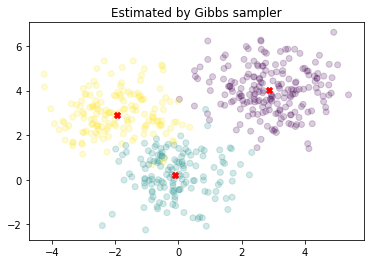

In [10]:
plt.scatter(model1.data[:,0], model1.data[:,1], c=model1.z, alpha=0.2)
plt.scatter(mu[:,0], mu[:,1], marker='X', color='red')
plt.title('Estimated by Gibbs sampler')

## 2. Finite HMM of Gaussians with known covariance

## 3. Dirichlet Process Mixture of Gaussian with known covariance

Here we consider a non-parametric version of mixture models with unbounded number of clusters with model density given by $p_G(x) = \sum_{j=1}^\infty \pi_j \phi(x|\phi_j, \sigma^2)$ with latent mixing measure $G = \sum_{j=1}^\infty \pi_j\delta_{\phi_j}$, with $\phi(x|\mu, \sigma^2)$ being the multivariate normal density at $x$ with mean $\mu\in\mathbb{R}^d$ and covariance $\sigma^2 I_d$ (we assume $\sigma^2$ is known. 

Prior: We posit the non-parametric prior on $G$ as $G\sim \text{DP}(\alpha G_0)$ where $\alpha>0$ is the prior concentration and $G_0\equiv N(\mu,\tau^2 I_d)$ being the base measure. We observe the data as $X_1,\dots,X_n|G\overset{iid}{\sim} P_G$.

Notes on the Dirichlet Process prior: The prior is given by the stick-breaking rule as follows - $\phi_1,\phi_2,\dots\overset{iid}{\sim} G_0$ and for $\pi\in\Delta^{\infty}$, $\pi\sim \text{GEM}(\alpha)$ which means $\beta_1,\beta_2,\dots \overset{iid}{\sim}\text{Beta}(1,\alpha)$ and $\pi_1=\beta_1, \dots, \pi_j = \beta_j \prod_{\ell<j} (1-\beta_\ell)$. The Dirichlet Process is a prior on the space of probability measures on a Polish space (thus $G$ is a random measure) with the following properties:
1. For any finite partition $A_1,\dots,A_K$ of the sample space, $(G(A_1),\dots,G(A_K))\sim\text{Dir}(\alpha G_0(A_1), \dots, \alpha G_0(A_K))$ (this was original definition as by Ferguson)
2. $G$ is almost surely discrete (McQueen et al)
3. The stick-breaking construction (Sethuraman)
4. Conjugacy: For the model $G\sim \text{DP}(\alpha G_0), Y_1,\dots,Y_n|G\overset{iid}{\sim} G$, we have $G|Y\sim\text{DP}(\alpha G_0 + \sum_{i=1}^n \delta_{Y_i})$, i.e. the posterior concentration is $\alpha+n$ and the posterior base measure is $\frac{\alpha}{\alpha+n}G_0 + \frac{n}{\alpha+n}\frac{1}{n}\sum_{i=1}^n \delta_{Y_i}$ (weighted mean of prior base measure and empirical distribution).
5. Connection to Polya Urn (or Chinese Restaurant Process): The marginal distribution of $Y_1,\dots,Y_n$ in the above by marginalizing out the random $G$ is complicated but can be expressed elegantly in a sequential manner as follows: $Y_1\sim G_0$ and for $j>1$, $Y_j|Y_1,\dots,Y_{j-1} \sim \frac{\alpha}{\alpha+n}G_0 + \frac{n}{\alpha+n}\frac{1}{n}\sum_{i=1}^{j-1} \delta_{Y_i}$.

### MCMC for this model

Bringing in auxiliary variables $Z_1,\dots,Z_n$ to denote allocation to cluster, the model becomes: with $\pi\in\Delta^{\infty}$ and $\phi_1,\phi_2,\dots \in \mathbb{R}^d$, $Z_i|\pi\overset{iid}{\sim}\text{Cat}(\pi)$ and $X_i|Z_i=k\sim N(\phi_k, \sigma^2 I_d)$, hence the joint model can be written as
$$p(\beta,\phi,Z,X) = \text{Beta}(1,\alpha)^\infty \times G_0^\infty \times \prod_{i=1}^n \pi_{z_i} \times \prod_{i=1}^n \phi(x_i|\phi_{z_i}, \sigma^2 I).$$

The main challenge is due to the infinitely many random variables associated while we have finitely many observations. The critical idea is to introduce some more auxiliary variables $u = (u_1,\dots,u_n)$ such that for each $i$ $u_i|\pi,Z \sim \text{U}[0,\pi_{z_i}]$ - this gives the idea of \textbf{Slice sampling}, which involves designing a MCMC for the joint model:
$$p(\beta,\phi,U,Z,X) = \text{Beta}(1,\alpha)^\infty \times G_0^\infty \times \prod_{i=1}^n \boldsymbol{1}(u_i<\pi_{z_i})  \times \prod_{i=1}^n \phi(x_i|\phi_{z_i}, \sigma^2 I).$$

Main idea: Given this construction, when conditioned on $u$, only need to sample for $\pi_j$ such that $\pi_{z_i}>u_i$, in other words $z_i$ comes from the level sets $H(u_i) = \{j\in\mathbb{N}_+| \pi_j>u_i\}$ - requires finite amount of computation (we only focus on those $\phi_j$ such that at least one of $z_i$ is $j$ (only the components in action).

The Gibbs sampler:

1. Sampling $U$ given others: For $i=1,\dots,n$, draw $u_i\overset{iid}{\sim}\text{U}[0, \pi_{z_i}]$
2. Sampling $\beta$ given others: By conditional independence we only need to sample $\beta_j$ which determines the $\pi_j$'s with $j\in\cup_{i=1}^n H(u_i)$. For such a $j$, by Bayes rule, $\beta_j|\text{rest}\sim \text{Beta}(1+m_j, \alpha+\sum_{k>j} m_k)$ with $m_j = \sum_{i=1}^n \boldsymbol{1}(z_i=j, u_i<\pi_j)$. Clearly in this update only indices $j=1,\dots,K$ are used for some finite $K$ (which may vary from iteration to iterations) with $m_k=0$ for all $k>K$.
3. Sampling $\phi$ given others: This is simple, given the allocations $Z$, the posteriors are the same as in the finite mixture case, using Gaussian prior-likelihood conjugacy. (prior comes through $G_0$ in DP)
4. Sampling $Z$ given others: We have for $j\in \cup_i H(u_i)$, $p(z_i=j|\text{rest}) \propto \boldsymbol{1}(u_i<\pi_j) \pi_j \times \phi(x_i|\phi_j, \sigma^2 I_d)$ - note that this is only positive if $\pi_j>u_i$, so it suffices to update for all $j=1,\dots,K$ where $1-\sum_{k=1}^K \pi_k < \min_{i\in [n]} \{u_i\}$. Note that there will be a situation (once in a while) that we have a new sample for some index $k$ for which $(\pi_k, \phi_k)$ have not yet been generated - when this happens, initialize by drawing from prior: $\phi_k\sim G_0, \beta_k\sim \text{Beta}(1,\alpha)$ and $\pi_k = \beta_k \prod_{i<k} (1-\beta_i)$.

In [12]:
class MCMC_DPmixture:
    def __init__(self, alpha, G0):
        self.alpha = alpha
        self.mu = np.array(G0[0])
        self.tau2 = G0[1]
        self.d = len(self.mu)
        self.data = None
        self.n = 0
        self.sigma2 = 1.
        
        self.z = None
        self.u = None
        self.beta = None
        self.pi = None
        self.phi = None
        self.K = 0
        
        self.B = 1000
        self.M = 50
        self.gap = 10
        
    def fit(self, data):
        n,d = np.shape(data)
        if d!= self.d:
            raise ValueError("incorrect dimension")
        if self.n == 0:
            self.data = data
            self.n = n
            self.initialize()
        else:
            self.n = self.n + n
            self.data = np.vstack(self.data, data)
        self.slice_sampler()
    
    def initialize(self):
        self.u = np.array([np.random.uniform(0,1, size=1)[0] for i in range(self.n)])
        self.beta = np.random.beta(1, self.alpha, size=self.n)
        self.update_pi()
        K = len(self.pi)
        self.z = np.random.choice(K, p=self.pi, size=self.n)
        self.phi = np.zeros((K, self.d))
        for i in range(K):
            idx = np.where(self.z == i)[0]
            if len(idx)>0:
                X = self.data[idx, :]
                self.phi[i,:] = np.mean(X, axis=0)
            else:
                self.phi[i, :] = np.random.multivariate_normal(self.mu, self.tau2*np.eye(self.d), size=1)[0]
        self.K = K
    
    def get_H(self):
        idx = set()
        for i in range(self.n):
            idx = idx.union(set(np.where(self.pi>self.u[i])[0]))
        idx = np.array(list(idx))
        return idx
    
    def get_m(self, j):
        return np.sum((self.z==j)*(self.u<self.pi[j]))
    
    def update_pi(self):
        K = len(self.beta)
        prod = 1.
        pi = np.zeros(K+1)
        for i in range(K):
            pi[i] = prod*self.beta[i]
            prod = prod*(1-self.beta[i])
            if np.sum(pi)>1:
                break
        pi[K] = 1. - np.sum(pi[0:K])
        #print(pi)
        self.pi = pi
        
    def slice_sampler(self):
        B, M, gap = self.B, self.M, self.gap
        T = B + (M-1)*gap
        import time
        time_start = time.time()
        for i in range(T):
            # update U
            self.u = np.array([np.random.uniform(0,self.pi[self.z[i]], size=1)[0] for i in range(self.n)])
            
            # update beta (and pi)
            idx = self.get_H()
            m = np.array([self.get_m(j) for j in range(self.K-1)])
            for j in idx:
                self.beta[j] = np.random.beta(1+m[j], self.alpha+np.sum(m[j:]), size=1)[0]
            self.update_pi()
            
            # update phi
            for i in range(self.K):
                idx = np.where(self.z == i)[0]
                if len(idx)>0:
                    X = self.data[idx,:]
                    mu_pos, sigma2_pos = posterior(X, self.mu, self.tau2, self.sigma2)
                    self.phi[i] = np.random.multivariate_normal(mu_pos, sigma2_pos*np.eye(self.d),size=1)[0]
            
            # update Z
            idx = self.get_H()
            #print(idx)
            for i in range(self.n):
                x = self.data[i,:]
                pi = self.pi
                p = np.array([(self.u[i]<pi[j])*phi(x,self.phi[j,:], self.sigma2) for j in idx])
                #print(p)
                if np.sum(p)>0:
                    p = p/np.sum(p)
                    s = np.random.choice(idx, p=p, size=1)[0]
                    self.z[i] = s
                else:
                    s = 0
                    while s in idx:
                        s = s+1
                    self.z[i] = s
        print('Time taken:', np.round(time.time()-time_start,2), 'seconds for', T, 'iterations')
        
    def get_parameter_estimates(self):
        z = self.z
        z_unique = np.unique(z)
        K = len(z_unique)
        print(K, 'clusters found')
        phi_hat = self.phi[z_unique, :]
        pi = self.pi[z_unique]
        return phi_hat, pi/np.sum(pi)

In [ ]:
model2 = MCMC_DPmixture(1, ([0,0], 1.))
model2.fit(data_mixture)

In [ ]:
model2.get_parameter_estimates()
γ